In [1]:
#Sentiment Analysis using n-gram word size.

In [2]:
# 90: 10 Train:Test ratio
# http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

In [24]:
from nltk.corpus import stopwords
import string
import re
from os import listdir
from pickle import dump, load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.models import load_model
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [6]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# prepare regex for char filtering
	re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	# remove punctuation from each word
	tokens = [re_punc.sub('', w) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	tokens = ' '.join(tokens)
	return tokens

# load all docs in a directory
def process_docs(directory, is_train):
	documents = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip any reviews in the test set
		if is_train and filename.startswith('cv9'):
			continue
		if not is_train and not filename.startswith('cv9'):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load the doc
		doc = load_doc(path)
		# clean doc
		tokens = clean_doc(doc)
		# add to list
		documents.append(tokens)
	return documents

# load and clean a dataset
def load_clean_dataset(is_train):
	# load documents
	neg = process_docs('txt_sentoken/neg', is_train)
	pos = process_docs('txt_sentoken/pos', is_train)
	docs = neg + pos
	# prepare labels
	labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
	return docs, labels

# save a dataset to file
def save_dataset(dataset, filename):
	dump(dataset, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load and clean all reviews
train_docs, ytrain = load_clean_dataset(True)
test_docs, ytest = load_clean_dataset(False)
# save training datasets
save_dataset([train_docs, ytrain], 'train.pkl')
save_dataset([test_docs, ytest], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


In [8]:
# load a clean dataset
def load_dataset(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

# define the model
def define_model(length, vocab_size):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, 100)(inputs3)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	model.summary()
	#plot_model(model, show_shapes=True, to_file='model.png')
	return model

# load training dataset
trainLines, trainLabels = load_dataset('train.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
# define model
model = define_model(length, vocab_size)
# fit model
model.fit([trainX,trainX,trainX], trainLabels, epochs=7, batch_size=16)
# save the model
model.save('model.h5')

Max document length: 1380
Vocabulary size: 44277
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1380)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1380)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1380)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1380, 100)    4427700     input_4[0][0]                    
____________________________________________________________

In [10]:
# load a clean dataset
def load_dataset(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

# load datasets
trainLines, trainLabels = load_dataset('train.pkl')
testLines, testLabels = load_dataset('test.pkl')
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
print('Max document length: %d' % length)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
# load the model
model = load_model('model.h5')
# evaluate model on training dataset
_, acc = model.evaluate([trainX,trainX,trainX], trainLabels, verbose=0)
print('Train Accuracy: %.2f' % (acc*100))
# evaluate model on test dataset dataset
_, acc = model.evaluate([testX,testX,testX], testLabels, verbose=0)
print('Test Accuracy: %.2f' % (acc*100))

Max document length: 1380
Vocabulary size: 44277
Train Accuracy: 100.00
Test Accuracy: 88.50


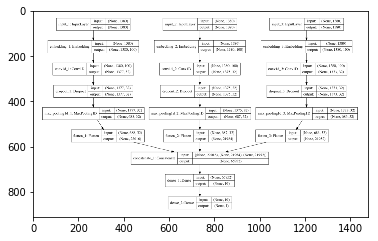

In [17]:
img = mpimg.imread('model_plt.png')
plt.imshow(img)
plt.show()

In [18]:
tokenizer.word_index

{'sonja': 30261,
 'astrosbraves': 28102,
 'woods': 1331,
 'spiders': 15778,
 'darryls': 22258,
 'hanging': 2038,
 'woody': 937,
 'comically': 8246,
 'localized': 38079,
 'sevens': 38371,
 'movietv': 33397,
 'canes': 32151,
 'canet': 30048,
 'hermans': 39984,
 'scold': 24692,
 'originality': 2149,
 'caned': 31451,
 'rickman': 7281,
 'wracked': 39953,
 'trojan': 40679,
 'stipulate': 27384,
 'ambulancechaser': 41725,
 'capoeira': 35391,
 'rawhide': 41994,
 'taj': 40446,
 'antimilitary': 41425,
 'bringing': 1466,
 'chekirk': 26462,
 'emilys': 26358,
 'liaisons': 8843,
 'grueling': 38966,
 'sommerset': 15937,
 'wooden': 2679,
 'wednesday': 12957,
 'mohrs': 29083,
 'circuitry': 18381,
 'crotch': 8629,
 'elgar': 25450,
 'seahavens': 36677,
 'stereotypical': 2920,
 'shows': 204,
 'bazooms': 31370,
 'insular': 19285,
 'snuggles': 31199,
 'francesco': 22059,
 'alzhiemers': 34317,
 'feasibility': 34472,
 'miniatures': 22652,
 'gorman': 25404,
 'sustaining': 14209,
 'consenting': 29992,
 'scraped'

In [19]:
#Visualization

In [22]:
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
['this', 'is', 'the', 'second', 'sentence'], ['yet', 'another', 'sentence'],
['one', 'more', 'sentence'],
['and', 'the', 'final', 'sentence']]
# train model
model1 = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model1)
# summarize vocabulary
words = list(model1.wv.vocab) 
print(words)
# access vector for one word print(model['sentence'])
# save model
model1.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin') 
print(new_model)

Word2Vec(vocab=14, size=100, alpha=0.025)
['and', 'word2vec', 'for', 'sentence', 'this', 'is', 'one', 'second', 'another', 'the', 'first', 'yet', 'final', 'more']
Word2Vec(vocab=14, size=100, alpha=0.025)


/Users/rajendraranabhat/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


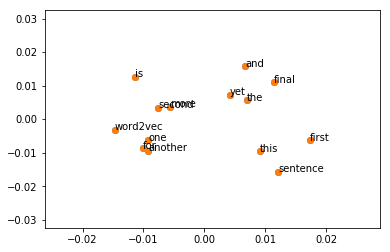

In [28]:
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model1 = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
X = model1[model1.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(model1.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()